<a href="https://colab.research.google.com/github/vsstejas777/Image-segmentation-of-OD-OC-using-Keras/blob/main/unet_segmentation_for_fundus_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import zipfile
import cv2
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
import albumentations as A
import random
from tensorflow.keras.layers import Input,Conv2D,Lambda,Dropout,MaxPooling2D,Conv2DTranspose,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import custom_object_scope
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix

In [13]:
img_paths=['/content/drive/MyDrive/glaucoma-datasets/G1020/Images_Cropped/img/*.jpg',
           '/content/drive/MyDrive/glaucoma-datasets/ORIGA/Images_Cropped/*',
           '/content/drive/MyDrive/glaucoma-datasets/REFUGE/train/Images_Cropped/*'] #Adjust Paths Accordingly


mask_paths=['/content/drive/MyDrive/glaucoma-datasets/G1020/Masks_Cropped/img/*.png',
           '/content/drive/MyDrive/glaucoma-datasets/ORIGA/Masks_Cropped/*',
           '/content/drive/MyDrive/glaucoma-datasets/REFUGE/train/Masks_Cropped/*']

In [6]:
#Function for loading images from paths

def load_and_transform(img_paths, mask_paths):
    transformed_images = []
    transformed_masks = []


    for img_path, mask_path in zip(img_paths, mask_paths):

        images = glob.glob(img_path)
        masks = glob.glob(mask_path)

        for image_path, mask_path in zip(images, masks):

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image ,(128,128))

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask= cv2.resize(mask,(128,128))

            mask=np.expand_dims(mask,axis=-1)
            transformed_images.append(image)
            transformed_masks.append(mask)

    transformed_images = np.array(transformed_images)
    transformed_masks = np.array(transformed_masks,dtype='float32')

    return transformed_images, transformed_masks

In [14]:
images,masks=load_and_transform(img_paths,mask_paths) #loading the images and masks

In [15]:
print(f"Shape of images: {images.shape}")
print(f"Shape of Masks: {masks.shape}")

Shape of images: (2070, 128, 128, 3)
Shape of Masks: (2070, 128, 128, 1)


In [16]:
# Encode mask labels using LabelEncoder
le = LabelEncoder()

# Flatten masks to 1D for encoding
masks_flat = masks.reshape(-1, 1)

# Fit and transform labels to integers
masks_flat_enc = le.fit_transform(masks_flat)

# Reshape back to original mask shape
masks_reenc = masks_flat_enc.reshape(2070, 128, 128)

# Convert to one-hot encoded format (3 classes)
masks_categorical = to_categorical(masks_reenc, num_classes=3)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
print(f"Shape of Categorical_Masks: {masks_categorical.shape}")

Shape of Categorical_Masks: (2070, 128, 128, 3)


In [18]:
# Split data into training and test sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(images, masks_categorical, test_size=0.20)

In [19]:
print(f"Shape of Training images: {x_train.shape}")
print(f"Shape of Training Masks: {y_train.shape}")
print(f"Shape of Test images: {x_test.shape}")
print(f"Shape of Test Masks: {y_test.shape}")

Shape of Training images: (1656, 128, 128, 3)
Shape of Training Masks: (1656, 128, 128, 3)
Shape of Test images: (414, 128, 128, 3)
Shape of Test Masks: (414, 128, 128, 3)


In [20]:
## custom loss function
def dice_coefficient(y_true, y_pred, epsilon=1e-7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)

    dice_score = (2. * intersection + epsilon) / (union + epsilon)
    return dice_score

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)



In [21]:
# U-Net Model for Image Segmentation

# This model uses a U-Net architecture with:
# - Input shape: 128x128 RGB images
# - Data augmentation (random contrast and brightness)
# - Convolutional blocks with batch normalization and dropout
# - Encoder-decoder structure (contraction and expansion paths)
# - Softmax output for multi-class segmentation (3 classes)

# The model is compiled with a custom Dice loss and metric, optimized using Adam.

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])


IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3

num_classes=3;

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
x=data_augmentation(inputs)
s=tf.keras.layers.Rescaling(1./255)(x)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = BatchNormalization()(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = BatchNormalization()(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = BatchNormalization()(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = BatchNormalization()(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = BatchNormalization()(c3)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3 = BatchNormalization()(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = BatchNormalization()(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = BatchNormalization()(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = BatchNormalization()(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = BatchNormalization()(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = BatchNormalization()(c6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = BatchNormalization()(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = BatchNormalization()(c7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = BatchNormalization()(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = BatchNormalization()(c8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = BatchNormalization()(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = BatchNormalization()(c9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = BatchNormalization()(c9)

outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

with custom_object_scope({'dice_loss': dice_loss, 'dice_coefficient': dice_coefficient}):
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', dice_coefficient])
    model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]  

 Total params: 1,947,027 (7.43 MB)

 Trainable params: 1,944,083 (7.42 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [23]:
callback = EarlyStopping( patience=4, monitor="val_loss",restore_best_weights=True)
result = model.fit(
    x_train, y_train, batch_size=16, epochs=25, validation_data=(x_test, y_test), callbacks=[callback],verbose=1
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


104/104 ━━━━━━━━━━━━━━━━━━━━ 64s 289ms/step - accuracy: 0.6163 - dice_coefficient: 0.5801 - loss: 0.4199 - val_accuracy: 0.1821 - val_dice_coefficient: 0.1832 - val_loss: 0.8169
Epoch 2/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.8360 - dice_coefficient: 0.8296 - loss: 0.1704 - val_accuracy: 0.6168 - val_dice_coefficient: 0.6156 - val_loss: 0.3843
Epoch 3/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8364 - dice_coefficient: 0.8340 - loss: 0.1660 - val_accuracy: 0.7563 - val_dice_coefficient: 0.7559 - val_loss: 0.2441
Epoch 4/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8443 - dice_coefficient: 0.8428 - loss: 0.1572 - val_accuracy: 0.8021 - val_dice_coefficient: 0.8013 - val_loss: 0.1987
Epoch 5/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8387 - dice_coefficient: 0.8377 - loss: 0.1623 - val_accuracy: 0.8145 - val_dice_coefficient: 0.8138 - val_loss: 0.1861
Epoch 6/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8412 -

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


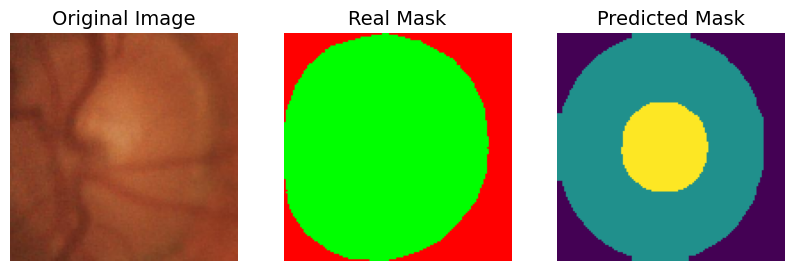

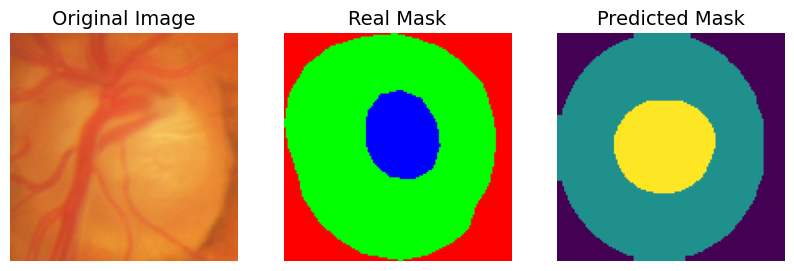

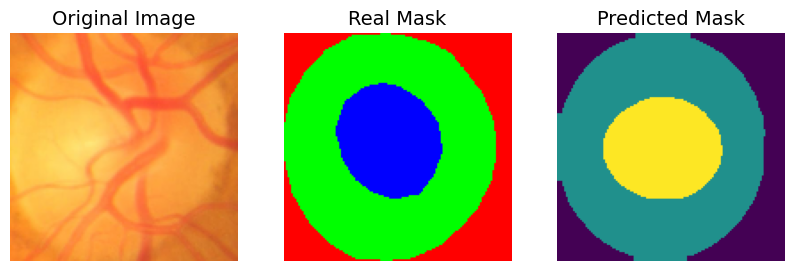

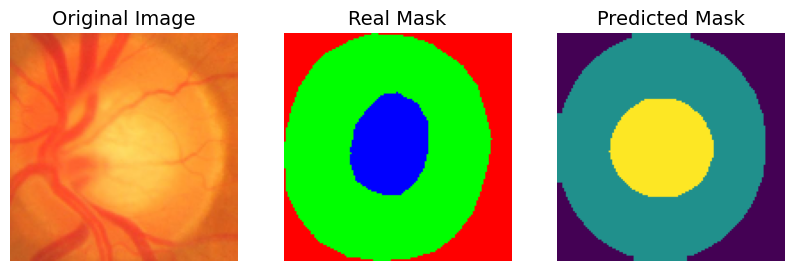

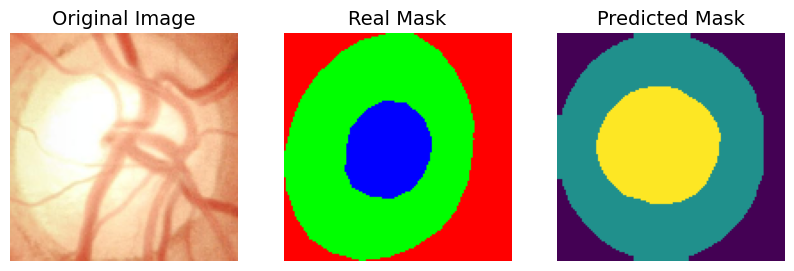

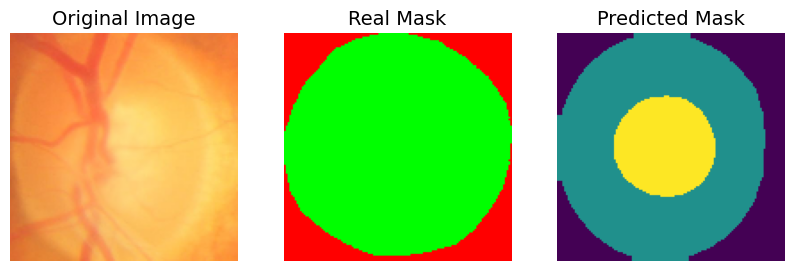

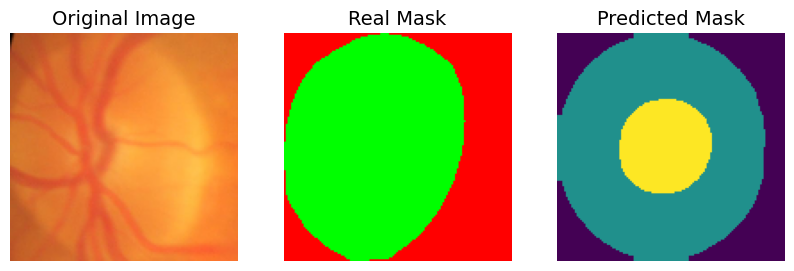

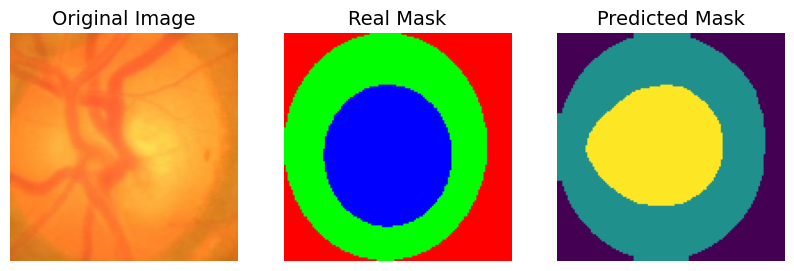

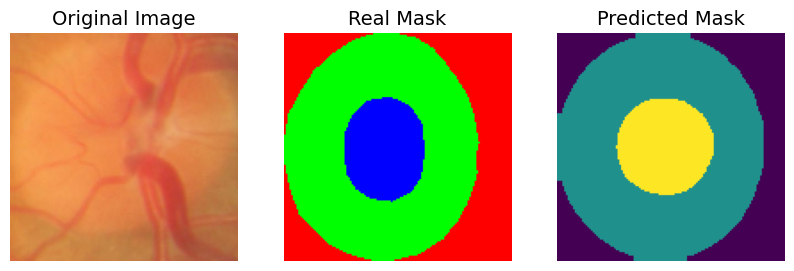

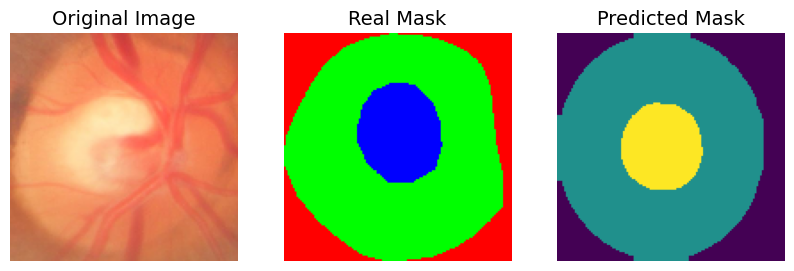

In [26]:
def apply_morphological_close(image, kernel_size=(5,5)):
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

# Predict masks for the test set and visualize results
# Applies morphological closing to smooth the predicted mask edges
# Displays the original image, ground truth mask, and predicted mask side by side for comparison

predictions = model.predict(x_test)
predicted_masks = (np.argmax(predictions, axis=-1)).astype(np.uint8)

for i in range(20,30):
    test_image = x_test[i, :, :, :]
    real_mask = y_test[i, :, :,:]
    predicted_mask = predicted_masks[i, :, :]

    predicted_mask = apply_morphological_close(predicted_mask)


    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title('Original Image', fontsize=14)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(real_mask)
    plt.title('Real Mask', fontsize=14)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title('Predicted Mask', fontsize=14)
    plt.axis('off')

    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
# Convert one-hot encoded test masks to class labels and flatten them
enc_masks = np.argmax(y_test, axis=-1)
enc_masks_flat = enc_masks.flatten()

# Flatten predicted masks for evaluation (e.g., accuracy, confusion matrix)
predicted_masks_flat = predicted_masks.flatten()



In [28]:
print(f"Shape of images: {enc_masks_flat.shape}")
print(f"Shape of Masks: {predicted_masks_flat.shape}")

Shape of images: (6782976,)
Shape of Masks: (6782976,)


In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy=accuracy_score(enc_masks_flat,predicted_masks_flat)
print(accuracy)
conf_matrix = confusion_matrix(enc_masks_flat,predicted_masks_flat)
print(conf_matrix)

0.8418711786684783
[[1718706  233477    3101]
 [ 201525 3119304  290246]
 [    102  344133  872382]]


In [30]:
evals=model.evaluate(x_test,y_test,batch_size=16,verbose=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8410 - dice_coefficient: 0.8409 - loss: 0.1591


In [ ]:
np.save('/content/drive/MyDrive/unet_xtest.npy',x_test)
np.save('/content/drive/My Drive/unet_ytest.npy',y_test)
np.save('/content/drive/My Drive/unet_xtrain.npy',x_train)
np.save('/content/drive/My Drive/unet_ytrain.npy',y_train)